# Health Recommender System Using PySpark
Based on article by: [David Kabii](https://medium.com/analytics-vidhya/health-recommender-system-aceb558ed487)

### Imports

In [1]:
import random
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import PCA
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
spark = SparkSession.builder.appName('DifferentialDiagnosisSystem').getOrCreate()

In [3]:
SPARSE_MATRIX_CSV = './dataset/symptoms-disease_sparse-matrix.csv'
SYMPTOMS_CSV = './dataset/symptoms_id.csv'
DIAGNOSIS_CSV = './dataset/diseases_id.csv'

### Data Loading

In [4]:
diff = spark.read.csv(SPARSE_MATRIX_CSV, header=True, inferSchema=True)
sym = spark.read.csv(SYMPTOMS_CSV, header=True, inferSchema=True)
dia = spark.read.csv(DIAGNOSIS_CSV, header=True, inferSchema=True)

In [5]:
print('Symptoms: ')
sym.show(4)
print('Diagnosis: ')
dia.show(4)
print('Sparse Matrix: ')
diff.show(4)

Symptoms: 
+---+-------------------+
|syd|            symptom|
+---+-------------------+
|1.0|         pain chest|
|2.0|shortness of breath|
|3.0|          dizziness|
|4.0|           asthenia|
+---+-------------------+
only showing top 4 rows

Diagnosis: 
+---+--------------------+
|did|             disease|
+---+--------------------+
|  1|hypertensive disease|
|  2|            diabetes|
|  3|   depression mental|
|  4| depressive disorder|
+---+--------------------+
only showing top 4 rows

Sparse Matrix: 
+---+---+-------------------+
|syd|did|                wei|
+---+---+-------------------+
|1.0|  1|0.07692307692307693|
|2.0|  1|0.07692307692307693|
|3.0|  1|0.07692307692307693|
|4.0|  1|0.07692307692307693|
+---+---+-------------------+
only showing top 4 rows



In [6]:
df = diff.join(sym, ['syd'], how='inner')
df = df.join(dia, ['did'], how='inner')
# df.show(4)
df_pandasDf = df.toPandas()
df_pandasDf.head()

,did,syd,wei,symptom,disease
0,1,1.0,0.076923,pain chest,hypertensive disease
1,1,2.0,0.076923,shortness of breath,hypertensive disease
2,1,3.0,0.076923,dizziness,hypertensive disease
3,1,4.0,0.076923,asthenia,hypertensive disease
4,1,5.0,0.076923,fall,hypertensive disease


### Feature Engineering

In [7]:
stringIndexer = StringIndexer(inputCol='symptom', outputCol='symptom_index')
model = stringIndexer.setHandleInvalid('skip').fit(df)
indexed = model.transform(df)
# indexed.show(4)
indexed_pandasDf = indexed.toPandas()
indexed_pandasDf.head()

,did,syd,wei,symptom,disease,symptom_index
0,1,1.0,0.076923,pain chest,hypertensive disease,17.0
1,1,2.0,0.076923,shortness of breath,hypertensive disease,0.0
2,1,3.0,0.076923,dizziness,hypertensive disease,77.0
3,1,4.0,0.076923,asthenia,hypertensive disease,10.0
4,1,5.0,0.076923,fall,hypertensive disease,66.0


In [8]:
encoder = OneHotEncoder(dropLast=False, inputCol="symptom_index", outputCol="symptom_vec")
ohe = encoder.fit(indexed)
encoded = ohe.transform(indexed)
df = encoded
# df.show(4)
# print(df.count())
df_pandasDf = df.toPandas()
df_pandasDf.head()

,did,syd,wei,symptom,disease,symptom_index,symptom_vec
0,1,1.0,0.076923,pain chest,hypertensive disease,17.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,2.0,0.076923,shortness of breath,hypertensive disease,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,3.0,0.076923,dizziness,hypertensive disease,77.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,4.0,0.076923,asthenia,hypertensive disease,10.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1,5.0,0.076923,fall,hypertensive disease,66.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [9]:
stringIndexer = StringIndexer(inputCol='disease', outputCol='disease_index')
model = stringIndexer.setHandleInvalid('skip').fit(df)
indexed = model.transform(df)
# indexed.show(4)
indexed_pandasDf = indexed.toPandas()
indexed_pandasDf.head()

,did,syd,wei,symptom,disease,symptom_index,symptom_vec,disease_index
0,1,1.0,0.076923,pain chest,hypertensive disease,17.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",87.0
1,1,2.0,0.076923,shortness of breath,hypertensive disease,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",87.0
2,1,3.0,0.076923,dizziness,hypertensive disease,77.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",87.0
3,1,4.0,0.076923,asthenia,hypertensive disease,10.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",87.0
4,1,5.0,0.076923,fall,hypertensive disease,66.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",87.0


In [10]:
encoder = OneHotEncoder(dropLast=False, inputCol="disease_index", outputCol="disease_vec")
ohe = encoder.fit(indexed)
encoded = ohe.transform(indexed)
df = encoded
# df.show(4)
# print(df.count())
df_pandasDf = df.toPandas()
df_pandasDf.head()

,did,syd,wei,symptom,disease,symptom_index,symptom_vec,disease_index,disease_vec
0,1,1.0,0.076923,pain chest,hypertensive disease,17.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",87.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,2.0,0.076923,shortness of breath,hypertensive disease,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",87.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,3.0,0.076923,dizziness,hypertensive disease,77.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",87.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,4.0,0.076923,asthenia,hypertensive disease,10.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",87.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1,5.0,0.076923,fall,hypertensive disease,66.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",87.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [11]:
cols = ['symptom', 'disease']
for col in cols:
  scaler = MinMaxScaler(inputCol=col+"_vec", outputCol=col+"_vec_scaled")
  scalerModel = scaler.fit(df)
  scaledData = scalerModel.transform(df)
  df = scaledData
# df.show(4)
df_pandasDf = df.toPandas()
df_pandasDf.head()

,did,syd,wei,symptom,disease,symptom_index,symptom_vec,disease_index,disease_vec,symptom_vec_scaled,disease_vec_scaled
0,1,1.0,0.076923,pain chest,hypertensive disease,17.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",87.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,2.0,0.076923,shortness of breath,hypertensive disease,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",87.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,3.0,0.076923,dizziness,hypertensive disease,77.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",87.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,4.0,0.076923,asthenia,hypertensive disease,10.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",87.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1,5.0,0.076923,fall,hypertensive disease,66.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",87.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [12]:
VectorAssembler = VectorAssembler(inputCols=['symptom_vec_scaled', 'disease_vec_scaled'], outputCol='features')
df = VectorAssembler.transform(df)
# df.show(4)
df_pandasDf = df.toPandas()
df_pandasDf.head()

,did,syd,wei,symptom,disease,symptom_index,symptom_vec,disease_index,disease_vec,symptom_vec_scaled,disease_vec_scaled,features
0,1,1.0,0.076923,pain chest,hypertensive disease,17.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",87.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,2.0,0.076923,shortness of breath,hypertensive disease,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",87.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,3.0,0.076923,dizziness,hypertensive disease,77.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",87.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,4.0,0.076923,asthenia,hypertensive disease,10.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",87.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1,5.0,0.076923,fall,hypertensive disease,66.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",87.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [13]:
kmeans = KMeans(k=2, seed=1)
model = kmeans.fit(df.select('features'))
transformed = model.transform(df)
df = transformed
# df.show(4)
df_pandasDf = df.toPandas()
df_pandasDf.head()

,did,syd,wei,symptom,disease,symptom_index,symptom_vec,disease_index,disease_vec,symptom_vec_scaled,disease_vec_scaled,features,prediction
0,1,1.0,0.076923,pain chest,hypertensive disease,17.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",87.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,1,2.0,0.076923,shortness of breath,hypertensive disease,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",87.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,1,3.0,0.076923,dizziness,hypertensive disease,77.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",87.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
3,1,4.0,0.076923,asthenia,hypertensive disease,10.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",87.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,1,5.0,0.076923,fall,hypertensive disease,66.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",87.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


### Data Visualization

In [14]:
pca = PCA(k=2, inputCol='features', outputCol='pcaFeatures')
model = pca.fit(df)

In [15]:
result = model.transform(df).select('pcaFeatures')
pandasDf = result.toPandas()

In [16]:
dataX = []
dataY = []
for vec in pandasDf.values:
  dataX.extend([vec[0][0]])
  dataY.extend([vec[0][1]])

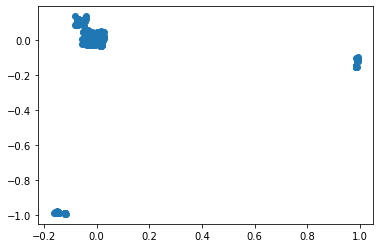

In [17]:
plt.scatter(dataX, dataY)
plt.show()

C:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


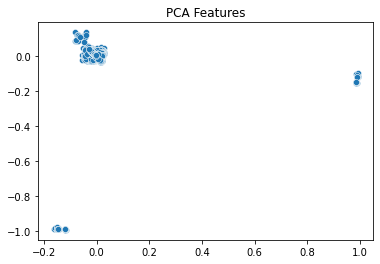

In [18]:
sns.scatterplot(dataX, dataY)
plt.title('PCA Features')
plt.show()

### Model Creation

In [19]:
df = df.na.drop(subset=['syd', 'disease_index', 'wei'])
df = df.drop('prediction')
# df.show(4)
# print(type(df))
df_pandasDf = df.toPandas()
df_pandasDf.head()

,did,syd,wei,symptom,disease,symptom_index,symptom_vec,disease_index,disease_vec,symptom_vec_scaled,disease_vec_scaled,features
0,1,1.0,0.076923,pain chest,hypertensive disease,17.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",87.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,2.0,0.076923,shortness of breath,hypertensive disease,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",87.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,3.0,0.076923,dizziness,hypertensive disease,77.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",87.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,4.0,0.076923,asthenia,hypertensive disease,10.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",87.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1,5.0,0.076923,fall,hypertensive disease,66.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",87.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [20]:
splits = df.randomSplit([0.75, 0.25], 24)
train= splits[0]
test = splits[1]
print('Training set size: ', train.count())
print('Testing set size: ', test.count())

Training set size:  1595
Testing set size:  532


In [21]:
rec = ALS(
          maxIter=10,
          regParam=0.01,
          userCol='syd',
          itemCol='disease_index',
          ratingCol='wei',
          nonnegative=True,
          coldStartStrategy='drop'
          )
rec_model = rec.fit(train)

### Model testing and evaluation

In [22]:
predicted_ratings = rec_model.transform(test)
# predicted_ratings.show(8)
predicted_ratings_pandasDf = predicted_ratings.toPandas()
predicted_ratings_pandasDf.head(8)

,did,syd,wei,symptom,disease,symptom_index,symptom_vec,disease_index,disease_vec,symptom_vec_scaled,disease_vec_scaled,features,prediction
0,72,148.0,0.050000,pain abdominal,diverticulitis,4.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",17.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.044922
1,79,148.0,0.090909,pain abdominal,sickle cell anemia,4.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",118.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.079335
2,98,148.0,0.100000,pain abdominal,tricuspid valve insufficiency,4.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",130.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.085146
3,106,148.0,0.100000,pain abdominal,neoplasm metastasis,4.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",128.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.086867
4,107,148.0,0.066667,pain abdominal,malignant tumor of colon,4.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",64.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.058718
5,109,148.0,0.066667,pain abdominal,ketoacidosis diabetic,4.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",62.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.058738
6,114,148.0,0.083333,pain abdominal,gastroenteritis,4.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",99.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.072511
7,125,148.0,0.083333,pain abdominal,pyelonephritis,4.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",109.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.072846


In [23]:
evaluator = RegressionEvaluator(metricName='rmse', predictionCol='prediction', labelCol='wei')
rmse = evaluator.evaluate(predicted_ratings)
print('RMSE: ', rmse)

RMSE:  0.015334561802254397


In [24]:
wei_max_value = df.agg({'wei': 'max'}).collect()[0][0]
wei_min_value = df.agg({'wei': 'min'}).collect()[0][0]
nrmse = rmse / (wei_max_value - wei_min_value)
print('NRMSE: ', nrmse)

NRMSE:  0.05152412765557477


### Obtaining recommendations

In [25]:
print('Symptoms: cough')
sydId = 46
df1a = df.filter(df['syd'] == sydId).select('syd', 'did', 'disease_index', 'disease').orderBy('wei', ascending=False).distinct()
df1a.show(5)

recommendations = rec_model.transform(df1a).orderBy('prediction', ascending=False)
print('Recommendations: ')
recommendations.show(5, False)


Symptoms: cough
+----+---+-------------+--------------------+
| syd|did|disease_index|             disease|
+----+---+-------------+--------------------+
|46.0| 41|        114.0|         hepatitis C|
|46.0|132|         88.0|         neutropenia|
|46.0| 88|         48.0|pneumonia aspiration|
|46.0|121|         43.0|         hemorrhoids|
|46.0|130|        139.0|        pneumothorax|
+----+---+-------------+--------------------+
only showing top 5 rows

Recommendations: 
+----+---+-------------+----------------------------------+----------+
|syd |did|disease_index|disease                           |prediction|
+----+---+-------------+----------------------------------+----------+
|46.0|8  |144.0        |failure heart congestive          |0.12247357|
|46.0|10 |132.0        |asthma                            |0.09669579|
|46.0|130|139.0        |pneumothorax                      |0.09342414|
|46.0|133|135.0        |hyperbilirubinemia                |0.09341442|
|46.0|16 |122.0        |chroni

In [26]:
print('Symptoms: pain chest, palpitation, shortness of breath, sweat')
sydId1 = 1
sydId2 = 10
sydId3 = 2
sydId4 = 8
df1a = df.filter((df['syd'] == sydId1) | (df['syd'] == sydId2) |
                 (df['syd'] == sydId3) | (df['syd'] == sydId4)).select('syd', 'did', 'disease_index', 'disease').orderBy('wei', ascending=False)
df1a.show(5)

recommendations = rec_model.transform(
    df1a).orderBy('prediction', ascending=False)
print('Recommendations: ')
recommendations.show(5, False)


Symptoms: pain chest, palpitation, shortness of breath, sweat
+---+---+-------------+--------------------+
|syd|did|disease_index|             disease|
+---+---+-------------+--------------------+
|1.0|103|        146.0|      kidney disease|
|2.0|103|        146.0|      kidney disease|
|2.0|  8|        144.0|failure heart con...|
|2.0| 83|        136.0|hypertension pulm...|
|2.0| 10|        132.0|              asthma|
+---+---+-------------+--------------------+
only showing top 5 rows

Recommendations: 
+---+---+-------------+------------------------+-----------+
|syd|did|disease_index|disease                 |prediction |
+---+---+-------------+------------------------+-----------+
|2.0|103|146.0        |kidney disease          |0.137677   |
|1.0|103|146.0        |kidney disease          |0.13609263 |
|2.0|8  |144.0        |failure heart congestive|0.124966115|
|2.0|10 |132.0        |asthma                  |0.09866327 |
|2.0|83 |136.0        |hypertension pulmonary  |0.09342411 |
+-